Setup stuff

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber

fiber_type: str = 'grin' # 'grin' or 'step'
grid_settings: dict = {'pixel_size': 26e-6 / 17, 'pixel_numbers': (34, 34)}
fiber_settings: dict = {'radius': 26e-6, 'wavelength': 1064e-9, 'n1': 1.465, 'n2': 1.45}

Generate the grid and the fiber

In [2]:
grid = Grid(**grid_settings)

if fiber_type.lower() in ['grin']:
    fiber = GrinFiber(**fiber_settings)
elif fiber_type.lower() in ['step', 'si']:
    fiber = StepIndexFiber(**fiber_settings)
else:
    raise ValueError(f"Unknown fiber type.")
print(fiber)

GrinFiber instance with:
  - Radius: 26.0 um
  - Core index: 1.465
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.209
  - Number of guided LP modes: 64
  - Number of guided LP modes (counting degenerates): 113
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[1.465      0.         0.         1.        ]
 [1.46407036 1.         0.         2.        ]
 [1.46314072 2.         1.         1.        ]
 [1.46314072 2.         0.         3.        ]
 [1.46221107 3.         1.         2.        ]
 [1.46221107 3.         0.         4.        ]
 [1.46128143 4.         2.         1.        ]
 [1.46128143 4.         1.         3.        ]
 [1.46128143 4.         0.         5.        ]
 [1.46035179 5.         2.         2.        ]]


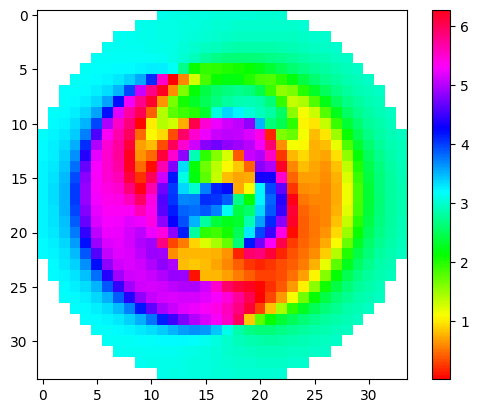

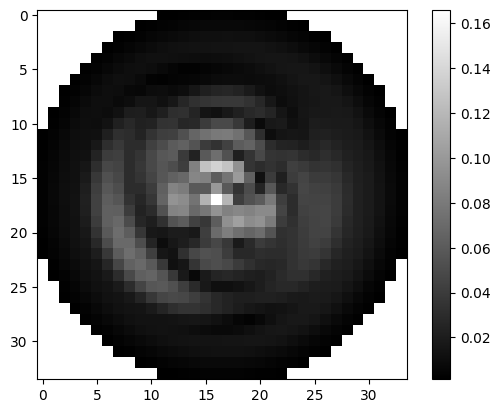

In [301]:
from mmfsim.speckle import DegenGrinSpeckle
from mmfsim.devices import load_nan_mask

nan_mask = load_nan_mask()

speckle = DegenGrinSpeckle(fiber, grid, N_modes=25)
speckle.compose()
speckle.field = speckle.field * np.exp(-1j * np.angle(speckle.field[0,0]))
speckle.field[nan_mask] = np.nan

plt.imshow(np.angle(speckle.field) + np.pi, cmap="hsv")
plt.colorbar()
plt.show()

plt.imshow(np.abs(speckle.field), cmap="gray")
plt.colorbar()
plt.show()

In [302]:
max_modes = 25
length = 10000
amps = np.nan * np.zeros(shape=(length, 34, 34), dtype=np.float32)
maps = np.nan * np.zeros(shape=(length, 34, 34), dtype=np.float32)
coeffs = np.nan * np.zeros(shape=(length, max_modes), dtype=np.complex64)

for i in range(length):
    speckle = DegenGrinSpeckle(fiber, grid, N_modes=max_modes)
    speckle.compose()
    speckle.field = speckle.field * np.exp(-1j * np.angle(speckle.field[0,0]))
    speckle.field[nan_mask] = np.nan
    amps[i, ...] = np.abs(speckle.field)
    maps[i, ...] = np.angle(speckle.field) + np.pi
    coeffs[i, ...] = speckle.modes_coeffs

Compute and store the modes for a much faster dataset generation, plot one for checking extent

In [299]:
print(maps.shape)

(10000, 34, 34)


In [304]:
print(.shape)

(10000, 1156)


In [303]:
from scipy.io import savemat

fiber_settings.update(dict(NA = fiber._NA))
save_string = f"input_speckles_degen_{fiber_type}_modes={max_modes}_r={fiber_settings['radius']*1e6:.0f}um_NA={fiber_settings['NA']:.3f}.mat"

savemat(
    file_name=save_string,
    mdict=dict(
        grid = grid_settings,
        fiber_type = fiber_type,
        fiber_settings = fiber_settings,
        modes = fiber._modes,
        max_modes = max_modes,
        Map = np.reshape(maps, newshape=(length, np.prod(maps.shape[-2:]))),
        Amp = np.reshape(amps, newshape=(length, np.prod(amps.shape[-2:]))),
        speckle_coeffs = coeffs,
        )
)
